# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values


In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 122
    lam = 0.1
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0.01, stddev=0.05, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean(BCE + KLD + softmax_loss)

            #loss = tf.clip_by_value(loss, -1, 1)
            loss = tf.where(tf.is_nan(loss), 1e-1, loss)

            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            #gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            #gradients = [
            #    None if gradient is None else tf.clip_by_value(gradient, -1, 1)
            #    for gradient in gradients]
            #self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
    
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())

            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:1})
                    
                    #summary_writer_train.add_summary(summary_str, epoch)
                    if(train_loss > 1e9):
                        print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                    

                valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                      feed_dict={net.x: preprocess.x_test, 
                                                                 net.y_: preprocess.y_test, 
                                                                 net.keep_prob:1})
                #summary_writer_valid.add_summary(summary_str, epoch)

                if epoch % 1 == 0:
                    print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))

            accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                           net.pred, 
                                                           net.actual, net.y], 
                                                          feed_dict={net.x: preprocess.x_test, 
                                                                     net.y_: preprocess.y_test, 
                                                                     net.keep_prob:1})


            print("Accuracy on Test data: {}".format(accuracy))
            
            curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1]})
            Train.predictions.update({"{}_{}_{}".format(epochs,f,h):curr_pred})
            
            if accuracy > Train.best_acc:
                Train.best_acc = accuracy
                Train.pred_value = pred_value
                Train.actual_value = actual_value
                Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                #net.saver.save(sess, "dataset/epochs_{}_hidden layers_{}_features count_{}".format(epochs,h,f))
            Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [2, 4, 8, 16, 32]
    hidden_layers_arr = [2, 4, 6]

    epochs = [10]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:10 hidden layers:2 features count:2
Step 1 | Training Loss: 0.012653 | Validation Accuracy: 0.797330
Step 2 | Training Loss: 0.005617 | Validation Accuracy: 0.853309
Step 3 | Training Loss: 0.025634 | Validation Accuracy: 0.863156
Step 4 | Training Loss: 0.011317 | Validation Accuracy: 0.853664
Step 5 | Training Loss: 0.012561 | Validation Accuracy: 0.855704
Step 6 | Training Loss: 0.018005 | Validation Accuracy: 0.870875
Step 7 | Training Loss: 0.026891 | Validation Accuracy: 0.864088
Step 8 | Training Loss: 0.081112 | Validation Accuracy: 0.833215
Step 9 | Training Loss: 0.126772 | Validation Accuracy: 0.873314
Step 10 | Training Loss: 0.027308 | Validation Accuracy: 0.816758
Accuracy on Test data: 0.816536545753479
Current Layer Attributes - epochs:10 hidden layers:2 features count:4
Step 1 | Training Loss: 1585879936.000000
Step 1 | Training Loss: 0.055691 | Validation Accuracy: 0.841421
Step 2 | Training Loss: 0.210659 | Validation Accuracy: 0.860

Step 2 | Training Loss: 0.205416 | Validation Accuracy: 0.780740
Step 3 | Training Loss: 0.184844 | Validation Accuracy: 0.818267
Step 4 | Training Loss: 0.060980 | Validation Accuracy: 0.844571
Step 5 | Training Loss: 0.013837 | Validation Accuracy: 0.865907
Step 6 | Training Loss: 0.010850 | Validation Accuracy: 0.826340
Step 7 | Training Loss: 0.023169 | Validation Accuracy: 0.845325
Step 8 | Training Loss: 0.041191 | Validation Accuracy: 0.829622
Step 9 | Training Loss: 0.067290 | Validation Accuracy: 0.833437
Step 10 | Training Loss: 8009700352.000000
Step 10 | Training Loss: inf
Step 10 | Training Loss: 0.100000 | Validation Accuracy: 0.569242
Accuracy on Test data: 0.5692423582077026
Current Layer Attributes - epochs:10 hidden layers:6 features count:4
Step 1 | Training Loss: 0.033690 | Validation Accuracy: 0.735850
Step 2 | Training Loss: 0.048714 | Validation Accuracy: 0.800435
Step 3 | Training Loss: 0.083818 | Validation Accuracy: 0.787926
Step 4 | Training Loss: 0.204293 | 

In [10]:
df_results = pd.DataFrame(Train.results)

In [11]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
4,10,32,2,0.890836,0.891102
7,10,8,4,0.875266,0.875355
1,10,4,2,0.869943,0.870653
2,10,8,2,0.854418,0.854462
8,10,16,4,0.841288,0.841377
12,10,8,6,0.835832,0.835788
0,10,2,2,0.816758,0.816537
14,10,32,6,0.807621,0.807621
9,10,32,4,0.790765,0.790853
5,10,2,4,0.764194,0.764194


In [12]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8853  0.1147]
 [ 0.1012  0.8988]]


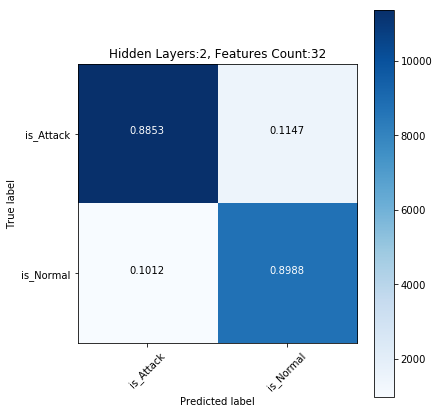

In [14]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)